In [1]:
import pandas as pd
import numpy as np
import os as os

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read data

In [35]:
path_project = '/content/drive/MyDrive/Mejora_la_red_de_bici_Madrid/data_adquisition_gsm_api/data_augmentation/black_and_white/'

###############
# Cyclist_type
###############
folder_cyclist_type = 'cyclist_type'
ls_file_cyclist_type = os.listdir(os.path.join(path_project,folder_cyclist_type))

###############
# generated_type -> sólo es booleano _> para qué se usa???
###############
folder_generated_type = 'generated_type'
ls_file_generated_type = os.listdir(os.path.join(path_project,folder_generated_type))

###############
# images_bw
###############
folder_images_bw = 'images_bw'
ls_file_images_bw = os.listdir(os.path.join(path_project,folder_images_bw))

#################
# Aggregate info
#################
df_data = pd.DataFrame(columns = {folder_cyclist_type, folder_images_bw})
if len(ls_file_cyclist_type) == len(ls_file_images_bw):
  for i in range(0,len(ls_file_cyclist_type)):
    df_aux = pd.DataFrame(columns = {folder_cyclist_type, folder_images_bw})

    df_aux[folder_cyclist_type] = np.load(os.path.join(path_project, folder_cyclist_type, ls_file_cyclist_type[i]))
    np_aux = np.load(os.path.join(path_project, folder_images_bw, ls_file_images_bw[i]))
    for j in range(0,len(np_aux)):
      df_aux[folder_images_bw].loc[j] = np_aux[j]

    df_data = pd.concat([df_data, df_aux])

In [36]:
df_data.head()

,images_bw,cyclist_type
0,"[[[253, 253, 253], [255, 255, 255], [244, 244,...",Itinerario recomendado
1,"[[[158, 158, 158], [158, 158, 158], [158, 158,...",Itinerario recomendado
2,"[[[159, 159, 159], [159, 159, 159], [159, 159,...",Itinerario recomendado
3,"[[[121, 121, 121], [124, 124, 124], [130, 130,...",Itinerario recomendado
4,"[[[177, 177, 177], [177, 177, 177], [177, 177,...",Itinerario recomendado


# Analysis data

In [38]:
df_analysis = df_data.copy()
ls_cyclist_type = df_analysis['cyclist_type'].unique()
print(ls_cyclist_type)

['Itinerario recomendado' 'Ciclocarril+carril bus' 'Ciclocarril'
 'Carril bici unidireccional en calzada' 'Calle 20'
 'Senda peatonal ciclable']


In [39]:
# Target is cyclist_type, that is a categorical variable, so, we assign a int to each feature
dict_cyclist_type = {'Itinerario recomendado': 1,
                     'Senda peatonal ciclable': 0,
                     'Ciclocarril': 1,
                     'Carril bici unidireccional en calzada': 0,
                     'Ciclocarril+carril bus': 0,
                     'Calle 20': 0}

df_analysis = df_analysis.rename(columns = {'cyclist_type':'cyclist_type_str'})
df_analysis['cyclist_type'] = df_analysis['cyclist_type_str'].apply(lambda row: dict_cyclist_type[row])
df_analysis.head()

# Define validation, train and test sets

In [41]:
# Configuration set
dict_set = {'pct_validation_set': 0.15,
            'SEED': 42,
            'test_size': 0.20
            }

In [42]:
# Labels are the values we want to predict
str_predict = 'cyclist_type'
labels_original = np.array(df_analysis[str_predict])
# Remove the labels from the features
features_original = df_analysis.drop([str_predict,'cyclist_type_str'], axis = 1)

## Validation set

In [43]:
# Define validation set according to the lenght of the data
n_validation_set = int(len(labels_original)*dict_set['pct_validation_set'])
y_validation = labels_original[0:n_validation_set]
X_validation = features_original.iloc[0:n_validation_set,:]
print('Validation Features Shape:', X_validation.shape)
print('Validation Labels Shape:', y_validation.shape)

Validation Features Shape: (241, 1)
Validation Labels Shape: (241,)


## Train and test sets

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
# Select set without validation set
features = features_original.iloc[n_validation_set:,:]
labels = labels_original[n_validation_set:]
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = dict_set['test_size'], random_state = dict_set['SEED'])

X_train = train_features
X_test = test_features
y_train = train_labels
y_test = test_labels

print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (1093, 1)
Training Labels Shape: (1093,)
Testing Features Shape: (274, 1)
Testing Labels Shape: (274,)


# Random Forest model

In [46]:
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [47]:
# Train the model using cross_validation. Kfold will allow to find the score of the model
dict_parameters_RF_model = {'n_split': 5,
                            'shuffle': True,
                            'scoreing': 'neg_mean_squared_error'
                            }

RF_model = RandomForestRegressor()
kf_model = KFold(dict_parameters_RF_model['n_split'], 
                 shuffle = dict_parameters_RF_model['shuffle'], 
                 random_state = dict_set['SEED']) # When shuffle is True, random_state affects the ordering of the indices

scores = cross_val_score(RF_model, 
                        X_train, 
                        y_train, 
                        scoring = dict_parameters_RF_model['scoreing'], 
                        cv = kf_model)

print(f'{np.abs(scores.mean()):.2f} MSE con una desviación de {scores.std():.3f}')

nan MSE con una desviación de nan


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
TypeError: only size-1 arrays can be converted to Python scalars

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 328, in fit
    X, y, multi_output=True, accept_sparse="csc", dtype=DTYPE
  File "/usr/local/lib/python

In [ ]:
# Hiperparameters analysis
from pprint import pprint
pprint(RF_model.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# Define parameters in order to execute GridSearchCV
dict_params = {'n_estimators': [1000, 1500, 2000],
               'max_depth': [5, 8, 15],
               'min_samples_split': [2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 5, 10],
               'max_features': ['auto', 'sqrt', 'log2']
               }

In [ ]:
RF_grid = RandomizedSearchCV(RandomForestRegressor(),
                             dict_params,
                             random_state = 0)
RF_grid.fit(X_train, 
            y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(),
                   param_distributions={'max_depth': [5, 8, 15],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 15,
                                                              100],
                                        'n_estimators': [1000, 1500, 2000]},
                   random_state=0)

In [ ]:
print('The best parameters are:')
dict_RF_best_parameters = RF_grid.best_params_
print(dict_RF_best_parameters)

The best parameters are:
{'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 15}


In [ ]:
# Find the mean squared error and $R^2$ of the best model created previously
RF_model = RandomForestRegressor(n_estimators = dict_RF_best_parameters['n_estimators'],
                                 min_samples_split = dict_RF_best_parameters['min_samples_split'],
                                 min_samples_leaf = dict_RF_best_parameters['min_samples_leaf'],
                                 max_features = dict_RF_best_parameters['max_features'],
                                 max_depth = dict_RF_best_parameters['max_depth'],
                                 random_state = 0)
RF_model.fit(X_train, y_train)
y_pred = RF_model.predict(X_test)

print(f'R2: {r2_score(y_test, y_pred):.2f}')

R2: -0.25


Text(0.5, 0, 'Real value')

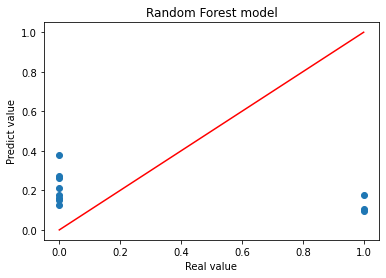

In [ ]:
# Plot the model
plt.scatter(y_test, y_pred)
plt.plot([0, 1], [0, 1], color='r')
plt.title('Random Forest model')
plt.ylabel('Predict value')
plt.xlabel('Real value')

## Make Predictions on the Test Set

In [ ]:
# Use the forest's predict method on the test data
predictions = RF_model.predict(X_train)
# Calculate the absolute errors
errors_l1 = abs(predictions - y_train)
errors_l2 = np.sqrt((predictions - y_train)**2)/len(predictions)
# Print out the mean absolute error (mae)
print('Error l1')
print('Mean Absolute Error:', round(np.mean(errors_l1), 2))
print('Max Error:', round(np.max(errors_l1), 2))
print('Min Error:', round(np.min(errors_l1), 2))
# Determine Performance Metrics
# Calculate mean absolute percentage error (MAPE)
mape_l1 = 100 * (errors_l1 / y_train)
# Calculate and display accuracy
accuracy_l1 = 100 - np.mean(mape_l1)
print('Accuracy l1:', round(accuracy_l1, 2), '%.')

print('------------------------------------')
print('Error l2')
print('Mean Absolute Error:', round(np.mean(errors_l2), 2))
print('Max Error:', round(np.max(errors_l2), 2))
print('Min Error:', round(np.min(errors_l2), 2))

# Determine Performance Metrics
# Calculate mean absolute percentage error (MAPE)
mape_l2 = 100 * (errors_l2 / y_train)
# Calculate and display accuracy
accuracy_l2 = 100 - np.mean(mape_l2)
print('Accuracy l2:', round(accuracy_l2, 2), '%.')

Error l1
Mean Absolute Error: 0.18
Max Error: 0.61
Min Error: 0.01
Accuracy l1: -inf %.
------------------------------------
Error l2
Mean Absolute Error: 0.0
Max Error: 0.02
Min Error: 0.0
Accuracy l2: -inf %.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in true_divide


# LDA Model -> Lineal Discriminant Analysis

In [ ]:
#Scale data
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

'\nX_train = sc.fit_transform(train_features)\nX_test = sc.transform(test_features)\n\ny_train = train_labels\ny_test = test_labels\n'

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

dict_parameters_LDA_model = {'n_components': 1}

LDA_model = LDA(n_components = dict_parameters_LDA_model['n_components'])

LDA_model.fit(X_train, y_train)
y_pred_LDA = LDA_model.predict(X_test)

In [ ]:
# Train and predict
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(max_depth = 2, 
                                    random_state = 0)

classifier = classifier.fit(X_train, X_test)
y_pred = classifier.predict(X_test)

ValueError: ignored

In [ ]:
# Evaluation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)
print('confusion matrix is: ' + str(cm))
print('Accuracy LDA Model is: ' + str(round(accuracy_score(y_test, y_pred),2)))
print('Classification Report is:')
print('')
print(classification_report(y_pred, y_test))

confusion matrix is: [[7 1]
 [3 0]]
Accuracy LDA Model is: 0.64
Classification Report is:

              precision    recall  f1-score   support

           0       0.88      0.70      0.78        10
           1       0.00      0.00      0.00         1

    accuracy                           0.64        11
   macro avg       0.44      0.35      0.39        11
weighted avg       0.80      0.64      0.71        11



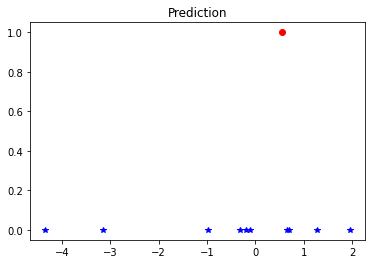

In [ ]:
# Plot prediction
import matplotlib.pyplot as plt
'''
plt.scatter(X_test, y_pred, marker='o')
plt.show()
'''
y_pred_1 = []
x_test_1 = []

y_pred_0 = []
x_test_0 = []
for i in range(0,len(y_pred)):
  if y_pred[i] == 1:
    y_pred_1.append(y_pred[i])
    x_test_1.append(X_test[i])
  else:
    y_pred_0.append(y_pred[i])
    x_test_0.append(X_test[i])

plt.plot(x_test_0, y_pred_0, 'b*')
plt.plot(x_test_1, y_pred_1, 'ro')
plt.title('Prediction')
plt.show()

# QDA model -> Quadratic Discriminant Analysis 

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA

ModuleNotFoundError: ignored

# Ver la distribución que siguen los datos (graficar) de los modelos anteriores

# KNN model

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

X_train = train_features
X_test = test_features
y_train = train_labels
y_test = test_labels

# Define model parameters
dict_parameters_KNN_model = {'n_neighbors': 2}

# Define model
KNN_model = KNeighborsClassifier(n_neighbors = dict_parameters_KNN_model['n_neighbors'])

# Adjust model
KNN_model.fit(X_train, y_train)
# Predict model
KNN_prediction = KNN_model.predict(X_test)  # Probar a meter el set de validacion, para ver que sale

In [ ]:
# Accuracy score is the simplest way to evaluate
print('Accuracy KNN model is: ' + str(round(accuracy_score(KNN_prediction, y_test),2)))
print('')
# Classification Report give more details about performance
print('Classification Report is:')
print('')
print(classification_report(KNN_prediction, y_test))

Accuracy KNN model is: 0.73

Classification Report is:

              precision    recall  f1-score   support

           0       1.00      0.73      0.84        11
           1       0.00      0.00      0.00         0

    accuracy                           0.73        11
   macro avg       0.50      0.36      0.42        11
weighted avg       1.00      0.73      0.84        11



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# DBSCAN model -> https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

In [ ]:
from sklearn.cluster import DBSCAN

X_train = train_features
X_test = test_features
y_train = train_labels
y_test = test_labels

# Define model parameters
dict_parameters_DBSCAN_model = {'eps':         1, #maximum distance between two samples
                                'min_samples': 2, #he number of samples (or total weight) in a neighborhood for a point to be considered as a core point
                                'metric':'euclidean'
                                }

# Define model
DBSCAN_model = DBSCAN(eps = dict_parameters_DBSCAN_model['eps'], 
                      min_samples = dict_parameters_DBSCAN_model['min_samples'], 
                      metric = dict_parameters_DBSCAN_model['metric'])

# Adjust model
DBSCAN_model = DBSCAN_model.fit(X_train, y_train)
# Predict model
DBSCAN_prediction = DBSCAN_model.fit_predict(X_test)

In [ ]:
# Accuracy score is the simplest way to evaluate
print('Accuracy DBSCAN model is: ' + str(round(accuracy_score(DBSCAN_prediction, y_test),2)))
print('')
# Classification Report give more details about performance
print('Classification Report is:')
print('')
print(classification_report(DBSCAN_prediction, y_test))

Accuracy DBSCAN model is: 0.0

Classification Report is:

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00      11.0
           0       0.00      0.00      0.00       0.0
           1       0.00      0.00      0.00       0.0

    accuracy                           0.00      11.0
   macro avg       0.00      0.00      0.00      11.0
weighted avg       0.00      0.00      0.00      11.0



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1